In [1]:
import os
os.chdir('..')

In [2]:
pwd

'C:\\Users\\nimee\\OneDrive\\Documents\\DDP\\Parametric_Roll_Detection'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from src.models.Model_OneShotDNN import OneShotDNN

In [5]:
# Dataset generator
n = 10
m = 5
hop = 0.25
input_dim   = 30 * n
pred_dim    = 30 * m
shift       = pred_dim
batch_size  = 16
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll', 'pitch']
                )

In [6]:
Data.Train.element_spec

(TensorSpec(shape=(None, 1200, 2), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 600, 1), dtype=tf.float64, name=None))

In [7]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [8]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

In [9]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 2]
Output dim: [600, 1]


In [9]:
norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
x_ds = Data.Train.map(lambda x, y: x)
norm.adapt(x_ds)

In [10]:
norm.variance.numpy()

array([[[15.116447  ,  0.60266036]]], dtype=float32)

In [16]:
acti = 'tanh'

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=INPUT_DIM))
# model.add(norm)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation=acti))
model.add(tf.keras.layers.Dense(1024, activation=acti))
model.add(tf.keras.layers.Dense(512, activation=acti))
model.add(tf.keras.layers.Dense(512, activation=acti))
model.add(tf.keras.layers.Dense(512, activation=acti))
model.add(tf.keras.layers.Dense(OUTPUT_DIM[0]))

In [18]:
model.compile(optimizer='adam', loss=MSE_loss, metrics=[MAPE, MAE])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2400)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)              2458624   
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 600)              

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min')

In [20]:
model.fit(Data.Train, epochs=100, validation_data=Data.Val, callbacks=[early_stopping])

Epoch 1/100
429/429 [==============================] - 21s 48ms/step - loss: 14.6048 - mean_absolute_percentage_error: 623.5654 - mean_absolute_error: 2.0308 - val_loss: 9.1582 - val_mean_absolute_percentage_error: 521.8699 - val_mean_absolute_error: 1.6111
Epoch 2/100
429/429 [==============================] - 21s 50ms/step - loss: 14.5458 - mean_absolute_percentage_error: 680.0574 - mean_absolute_error: 2.0472 - val_loss: 8.8669 - val_mean_absolute_percentage_error: 487.8422 - val_mean_absolute_error: 1.5689
Epoch 3/100
429/429 [==============================] - 21s 48ms/step - loss: 14.3139 - mean_absolute_percentage_error: 680.3942 - mean_absolute_error: 2.0339 - val_loss: 8.5513 - val_mean_absolute_percentage_error: 482.8152 - val_mean_absolute_error: 1.5434
Epoch 4/100
429/429 [==============================] - 20s 47ms/step - loss: 14.4277 - mean_absolute_percentage_error: 680.6069 - mean_absolute_error: 2.0385 - val_loss: 8.9473 - val_mean_absolute_percentage_error: 425.8905 - 

Epoch 33/100
429/429 [==============================] - 24s 55ms/step - loss: 11.1247 - mean_absolute_percentage_error: 646.7057 - mean_absolute_error: 1.7501 - val_loss: 7.3066 - val_mean_absolute_percentage_error: 662.6854 - val_mean_absolute_error: 1.4192
Epoch 34/100
429/429 [==============================] - 28s 64ms/step - loss: 11.1657 - mean_absolute_percentage_error: 652.6163 - mean_absolute_error: 1.7637 - val_loss: 7.2793 - val_mean_absolute_percentage_error: 689.1261 - val_mean_absolute_error: 1.4363
Epoch 35/100
429/429 [==============================] - 27s 63ms/step - loss: 11.1010 - mean_absolute_percentage_error: 670.7257 - mean_absolute_error: 1.7598 - val_loss: 7.3964 - val_mean_absolute_percentage_error: 709.1174 - val_mean_absolute_error: 1.4369
Epoch 36/100
429/429 [==============================] - 28s 65ms/step - loss: 10.9353 - mean_absolute_percentage_error: 707.1567 - mean_absolute_error: 1.7402 - val_loss: 7.3161 - val_mean_absolute_percentage_error: 703.667

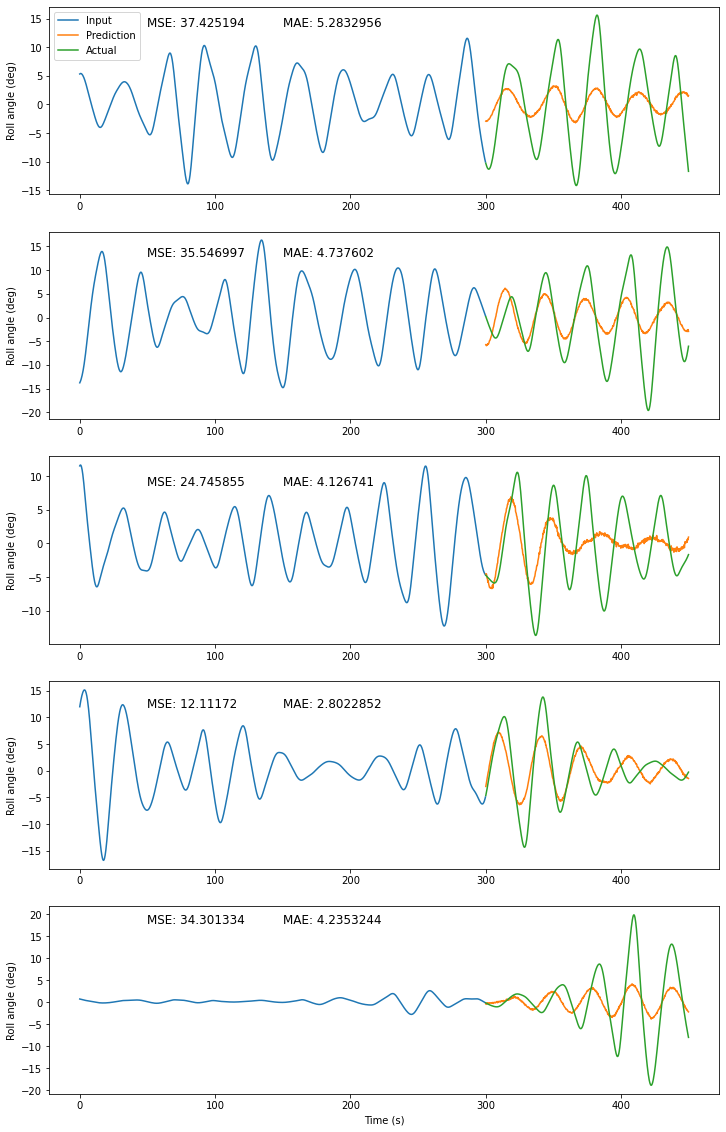

In [22]:
Data.plot_example(49, model, max_plots=5)

(16, 1200, 2)
tf.Tensor([6.91228834], shape=(1,), dtype=float64)
(16, 600, 1) (16, 600)
tf.Tensor(1.4001782, shape=(), dtype=float32)


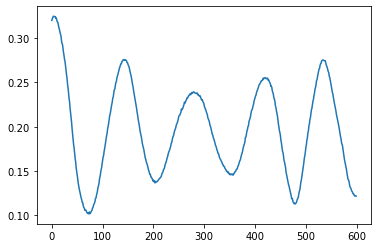

In [19]:
for x, y in Data.Example(50):
    y_pred = model(x)
    print(x.shape)
    print(max(y[0,:]))
    print(y.shape, y_pred.shape)
    print(MAE(y, y_pred))
    plt.plot(y_pred[0,:], label='y')
    plt.show()
    break

(16, 1200, 2)


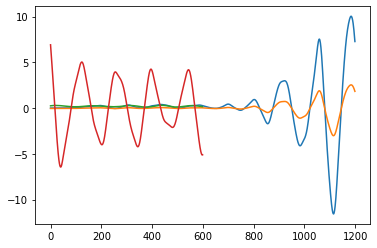

In [28]:
for x, y in Data.Example(50):
    x_norm = norm(x)
    y_pred = model(x_norm)
    print(x_norm.shape)
    plt.plot(x[0,:,0], label='x')
    plt.plot(x_norm[0,:,0], label='x_norm')
    plt.plot(y_pred[0,:])
    plt.plot(y[0,:])
    plt.show()
    break

In [15]:
oneshot_dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(INPUT_DIM,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_DIM, activation='linear')
])

In [13]:
MAX_EPOCHS_TRAINING = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS_TRAINING,
                      validation_data=window.Val,
                      callbacks=[early_stopping])
  return history

In [14]:
history_training = compile_and_fit(oneshot_dnn_model, data)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 120 and 60 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](my_model/dense_4/BiasAdd, Cast)' with input shapes: [?,120,60], [?,60,1].


In [29]:
val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

62/62 [==============================] - 2s 23ms/step - loss: 7.9224 - mean_absolute_percentage_error: 415.3475 - mean_absolute_error: 1.4855


In [30]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 5.61
Validation MAPE:     453.10
Validation MAE:      1.21
Test MSE_loss:       7.92
Test MAPE:           415.35
Test MAE:            1.49


In [23]:
model.save('models/oneshot_dnn_model')

INFO:tensorflow:Assets written to: models/oneshot_dnn_model\assets
